In [1]:
import pandas as pd
import numpy as np
import os
import glob
import numpy.random as rng
import random
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

In [2]:
class CreateLabelsTargets:
    def __init__(self,path):
        self.df = pd.read_csv(path)
        columns = list(self.df.columns.values)
        self.classes = []
        # Treating the columns in the csv for the two possible options
        if(columns[0] == 'Image'):
            self.columnImage = columns[0]
            self.columnId = columns[1]
        else:
            self.columnImage = columns[1]
            self.columnId = columns[0]
        
        self.numberOfClasses = self.df[self.columnId].nunique()
        
    def load_csv_and_treat(self):
        self.dict_classes = {}
        
        #Run in the df, creating a dictionary with the images and classes
        for index, row in self.df.iterrows():
            # ignore "new_whale"
            if(row[self.columnId] == 'new_whale' or row[self.columnImage] == 'new_whale'):
                continue
            
            if (not self.dict_classes.get(row[self.columnId])):
                self.dict_classes[row[self.columnId]] = []
                
            auxArray = self.dict_classes.get(row[self.columnId])
            auxArray.append(row[self.columnImage])
            self.dict_classes[row[self.columnId]] = auxArray
            
    def create_labels_and_targets(self):
        # Create  X_train, X_test, y_train, y_test, with only text values
        X=[]
        y=[]
        for key, value in self.dict_classes.items():
            X.append(value)
            y.append(key)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
        return (X_train, X_test, y_train, y_test)

    
    def create_dataset_with_image(self,imgsPath):
        # Create  X_train, X_test, y_train, y_test, with actual images
        X=[]
        y=[]
        IMG_DIM = (200,200)
        for key, values in self.dict_classes.items():
            self.classes.append(key)
            aux = []
            for value in values:
                fullPath = imgsPath + value
                img = load_img(fullPath, color_mode = "grayscale",target_size=IMG_DIM)
                aux.append(img_to_array(img))
                
            X.append(np.array(aux))
            y.append(key)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
        return (np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test))
             

In [82]:
class DataLoader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self, path, X,y):
        self.X = X
        self.y = y
        self.path = path
        self.w = 200
        self.h = 200
        self.datagen = ImageDataGenerator( 
            rotation_range = 40, 
            shear_range = 0.2, 
            zoom_range = 0.2, 
            horizontal_flip = True, 
            brightness_range = (0.8, 1.3)
        
    def getBatchRandom(self,batchSize,X):
        numberOfClasses = len(X)
        
        # initialize triplets
        triplets=[np.zeros((batchSize,self.h, self.w,1)) for i in range(3)]

        for i in range(batchSize):
            #Pick one random class for anchor
            anchorClass = np.random.randint(0, numberOfClasses)
            numberOfSamplesInAnchor = X[anchorClass].shape[0]
            
            # If class only have one image, try again and again...
            if(numberOfSamplesInAnchor < 2):
                while(numberOfSamplesInAnchor < 2):
                    anchorClass = np.random.randint(0, numberOfClasses)
                    numberOfSamplesInAnchor = X[anchorClass].shape[0]

            #Pick two different random pics for anchor and positive
            [indexAnchor,indexPositive] = np.random.choice(numberOfSamplesInAnchor,size=2,replace=False)

            #Pick class for negative image, different from anchor_class
            negativeClass = (anchorClass + np.random.randint(1,numberOfClasses)) % numberOfClasses

            #Pick a random pic for negative class
            indexNegative = np.random.randint(0, X[negativeClass].shape[0])

            triplets[0][i,:,:,:] = X[anchorClass][indexAnchor,:,:,:]
            triplets[1][i,:,:,:] = X[anchorClass][indexPositive,:,:,:]
            triplets[2][i,:,:,:] = X[negativeClass][indexNegative,:,:,:]

        return triplets
    
    def drawTriplets(self,tripletbatch, nbmax=None):
        labels = ["Anchor", "Positive", "Negative"]
        print(tripletbatch[0].shape[0])
        if (nbmax==None):
            nbrows = tripletbatch[0].shape[0]
        else:
            nbrows = min(nbmax,tripletbatch[0].shape[0])

        for row in range(nbrows):
            fig=plt.figure(figsize=(16,2))

            for i in range(3):
                subplot = fig.add_subplot(1,3,i+1)
                plt.imshow(array_to_img(tripletbatch[i][row]),cmap="gray")
                subplot.title.set_text(labels[i])
                
    def getBatchHard(self,batchSize,hardBatchSize,network,X):
        
        # Number of triplets that will stay random
        numberOfRandomTriplets = batchSize - hardBatchsSize
        m = len(X)
        
        # get random batch to study
        randomBatch = getBatchRandom(batchSize,X)

        # Array with zeros for future loss of randomBatch
        randomBatchLoss = np.zeros((batchSize))

        # Compute embeddings for anchors, positive and negatives
        A = network.predict(randomBatch[0])
        P = network.predict(randomBatch[1])
        N = network.predict(randomBatch[2])

        #Compute distance for all (A,P)-d(A,N) in randomBatch
        randomBatchLoss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)

        #Sort by distance (high distance first) and take the index of hard batches
        hardBatches = np.argsort(randomBatchLoss)[::-1][:hardBatchSize]

        # get random batch to complete batch_size, ignoring the batches from hardBatches
        randomBatches = np.random.choice(np.delete(np.arange(batchSize),hardBatches),numberOfRandomTriplets,replace=False)

        batch= np.append(hardBatches,randomBatches)
        
        triplets = [randomBatch[0][batch,:,:,:], randomBatch[1][batch,:,:,:], randomBatch[2][batch,:,:,:]]

        return triplets


In [63]:
createLabelsTargets = CreateLabelsTargets("train_HB.csv")
createLabelsTargets.load_csv_and_treat()
(X_train, X_test, y_train, y_test) = createLabelsTargets.create_labels_and_targets()

In [83]:
dataLoad = DataLoader(os.getcwd()+'/modelHB_imgs200/',X_train, y_train)

(pairs,targets) = dataLoad.make_oneshot_task(5,X_train,y_train)


(pairs,targets) = dataLoad.getBatch(4)

for index in range(len(pairs[0])):
    imgplot = plt.imshow(array_to_img(pairs[0][index]), cmap='gray')
    plt.title(str(index) + "_ " + str(targets[index]))
    plt.show()
    imgplot2 = plt.imshow(array_to_img(pairs[1][index]), cmap='gray')
    plt.title(str(index) + "_ " + str(targets[index]))
    plt.show()

In [66]:
imgsPath = os.getcwd()+'/modelHB_200/'
csvPath = 'train_HB.csv'
createLabelsTargets = CreateLabelsTargets(csvPath)
createLabelsTargets.load_csv_and_treat()
(X_train, X_test, y_train, y_test) = createLabelsTargets.create_dataset_with_image(imgsPath)

In [88]:
triples = dataLoad.getBatchRandom(4,X_test)
print(triples[0].shape)

(4, 200, 200, 1)


4


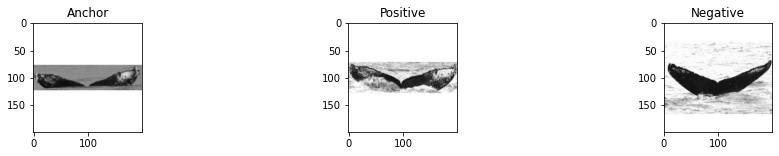

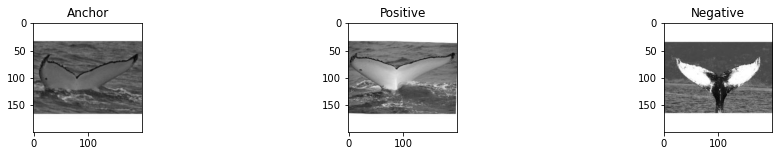

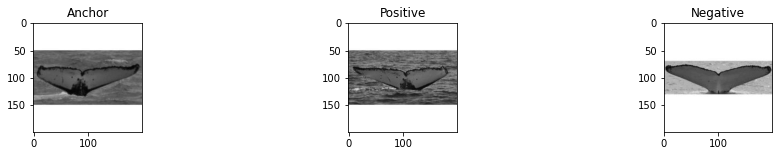

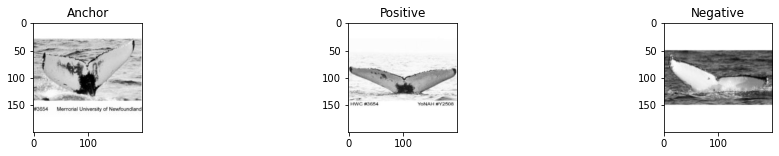

In [89]:
dataLoad.drawTriplets(triples,None)

old code

In [ ]:
 def getBatch(self,batch_size):
        """Create batch of n pairs, half same class, half different class"""
        n_classes = len(self.y)
        IMG_DIM = (self.w,self.h)
        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, self.w, self.h,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            #If category doesnt have two examples, it wont be good to equal test
            if (i >= batch_size // 2) and (len(self.X[category]) == 1):  
                while(len(self.X[category]) == 1):
                    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
                    category = categories[i]
            
            #Select first image
            n_examples = len(self.X[category])
            idx_1 = rng.randint(0, n_examples)
            fullPath = self.path + self.X[category][idx_1]
            img = load_img(fullPath, color_mode = "grayscale",target_size=IMG_DIM)
            pairs[0][i,:,:,:] = img_to_array(img)

            #pick category and index of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category
                idx_2 = (idx_1 + rng.randint(1,n_examples)) % n_examples
            else: 
                #add old category number to the category modulo n classes to ensure 2nd image has different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
                n_examples = len(self.X[category_2])
                idx_2 = rng.randint(0, n_examples)
            
            fullPath = self.path + self.X[category_2][idx_2]
            img = load_img(fullPath, color_mode = "grayscale",target_size=IMG_DIM)
            pairs[1][i,:,:,:] = img_to_array(img)
            
            # augmentation on data
            pair = rng.randint(0,1)
            augs = self.datagen.flow(pairs[pair], batch_size=1,shuffle=False)
            for i in range(len(augs)):
                pairs[pair][i,:,:,:] = augs[i][0]

        return pairs, targets

    def generate(self, batch_size):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.getBatch(batch_size)
            yield (pairs, targets)
            
    def make_oneshot_task(self,N,X,y):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        n_classes = len(y)
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        if(len(X[true_category]) == 1):
            while(len(X[true_category]) == 1):
                categories = rng.choice(range(n_classes),size=(N,),replace=False)            
                true_category = categories[0]

        n_examples = len(X[true_category])
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        
        # Load Image
        testImage = self.loadImageAsArray(X[true_category][ex1])
        testImage = np.asarray([testImage]*N)

        # Get first image equal to original
        supportSet = []
        supportSet.append(img_to_array(self.loadImageAsArray(X[true_category][ex2])))

        #Append the rest of the test images
        for category in categories:
            if(category == true_category):
                continue
            n_examples = len(X[category])
            index = rng.randint(0,n_examples)
            setImage = img_to_array(self.loadImageAsArray(X[category][index]))
            supportSet.append(setImage)

        supportSet = np.array(supportSet)
        #initialize targets equal zero
        targets = np.zeros((N,))
        targets[0] = 1
        targets, testImage, supportSet = shuffle(targets, testImage, supportSet)

        pairs = [testImage,supportSet]
        return pairs, targets
    
    def test_oneshot(self,model,N,k,X,y,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,X,y)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct